# SARSA and Q-Learning: Cliffworld Example

In this exercise we use the cliffworld example to implement SARSA and Q-Learning,
and to illustrate how their behavior differs.

For a detailed description of the setting see
[Example 6.6 in *Sutton & Barto*](http://incompleteideas.net/book/RLbook2020trimmed.pdf#page=154).

## Setup

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from gridworld import GridWorld 
from collections import defaultdict

# Use `tk` for interactive play, `inline` for normal plots:
# %matplotlib tk
%matplotlib inline

First, we recreate the setting from the example using our generic gridworld class.

*(How this is done is somewhat specific to our implementation and the details do not matter too much.)*

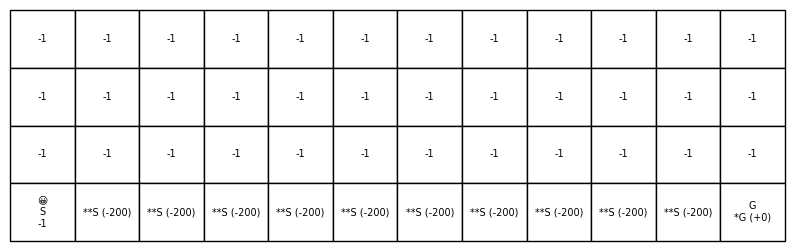

In [48]:
# Dimension and start/goal squares
HEIGHT = 4
WIDTH = 12
START = (HEIGHT - 1, 0)
GOAL = (HEIGHT - 1, WIDTH - 1)

# Create (empty) gridworld instance
gw = GridWorld(HEIGHT, WIDTH, START)

# Label start/goal
gw.positionLabels[START] = 'S'
gw.positionLabels[GOAL] = 'G'

# Add cliffs to the bottom row (except for corners)
for i in range(1, WIDTH - 1):
    gw.immediateTeleportations[(HEIGHT - 1, i)] = (START, -200)

# Make goal state terminal
gw.teleportations[GOAL] = (GOAL, 0)

# Give -1 reward for all other transitions
gw.rewards[START] = -1
gw.invalidActionReward = -1
for i in range(HEIGHT - 1):
    for j in range(WIDTH):
        gw.rewards[(i, j)] = -1

# A small chance of doing something random, just to make a point
gw.randomChance = 0.0

# Helper list, containing all possible states and actions
ALL_STATES = list((i, j) for i in range(gw.height) for j in range(gw.width))
ACTIONS = [0, 1, 2, 3]

# Plot the world
plt.figure(figsize=(10,3))
gw.drawWorld()
plt.show()

# # Play in the world
# gw.play()

Define some parameters used below.

In [49]:
# Learning rate
ALPHA = 0.1

# Exploration rate
EPSILON = 0.1

# Discount factor
GAMMA = 1.0

# Number of episodes in SARSA/Q-learning
N_EPISODES = 10000


## SARSA

In this section we implement SARSA to solve the cliff world environment.

We start by implementing a helper function that lets us choose an action in an epsilon-greedy manner, according to our current estimate of the state-action values $q(s,a)$.

In [50]:
def chooseEpsilonGreedy(allQValues, state, eps):
    # Choose random action with probability `eps`
    if np.random.uniform() < eps:
        return np.random.choice(ACTIONS)
    
    # Chose optimal action (breaking ties randomly)
    stateQValues = np.array(allQValues[state])
    qMax = np.max(stateQValues)
    optimalActions = np.argwhere(stateQValues == qMax).flatten()
    # optimalActions = [a for (a, q) in zip(ACTIONS, stateQValues) if q == qMax]
    return np.random.choice(optimalActions)


Next, we implement SARSA itself, following the pseudocode in *Sutton & Barto*, page 130.

In [51]:
# Initialize Q(s,a) arbitrarily
# Repeat (for each episode):
#     Initialize s
#     Choose a from s using policy derived from Q (e.g., epsilon-greedy)
#     Repeat (for each step of episode):
#         Take action a, observe r, s'
#         Choose a' from s' using policy derived from Q (e.g., epsilon-greedy)
#         Q(s,a) <- Q(s,a) + alpha * [r + gamma * Q(s',a') - Q(s,a)]
#         s <- s'; a <- a';
#     until s is terminal


In [52]:
def sarsaEpisode(world: GridWorld, qValues):
    # Initialize gridworld
    pos = world.reset()

    # Keep some records (not part of SARSA itself)
    totalRewards = 0.0
    path = [pos]

    # Choose first action from policy
    action = chooseEpsilonGreedy(qValues, pos, EPSILON)
    
    # Iterate until we reach a terminal state
    while pos != GOAL:
        # Take action, observe reward and new position
        newPos, reward = world.step(action)

        # Choose next action from policy
        newAction = chooseEpsilonGreedy(qValues, newPos, EPSILON)

        # Update Q-value
        target = reward + GAMMA * qValues[newPos][newAction]
        oldQ = qValues[pos][action]
        qValues[pos][action] = oldQ + ALPHA * (target - oldQ)

        # Update state, action
        action = newAction
        pos = newPos

        # Keep some records (not part of SARSA itself)
        totalRewards += reward
        path.append(newPos)

    return totalRewards, path


In [53]:
# Initialize Q(s,a) arbitrarily
sarsaQValues = dict()
for pos in ALL_STATES:
    sarsaQValues[pos] = np.zeros(4)
# or:
sarsaQValues = defaultdict(lambda: np.zeros(4))

# Keep track of things (not part of SARSA itself)
sarsaRewards = []
sarsaPaths = []

# Repeat (for each episode):
for i in range(N_EPISODES):
    [reward, path] = sarsaEpisode(gw, sarsaQValues)
    sarsaRewards.append(reward)
    sarsaPaths.append(path)


Lastly, we illustrate the result of SARSA by looking at the paths taken during training, the estimated value function, and the corresponding optimal policy.

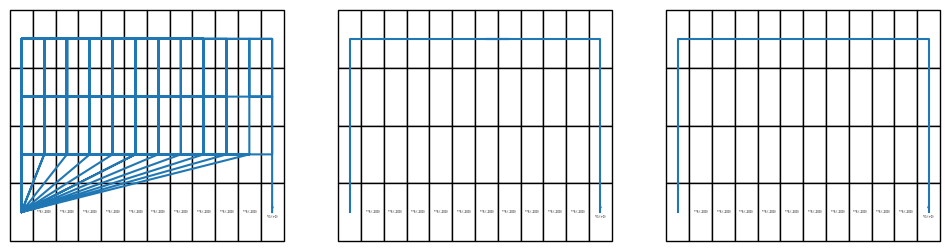

In [54]:
# Plot paths taken at various stages
plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 3, 1)
gw.drawWorld(ax, drawRewards=False, path=sarsaPaths[0])
ax = plt.subplot(1, 3, 2)
gw.drawWorld(ax, drawRewards=False, path=sarsaPaths[N_EPISODES // 2])
ax = plt.subplot(1, 3, 3)
gw.drawWorld(ax, drawRewards=False, path=sarsaPaths[-1])
plt.show()

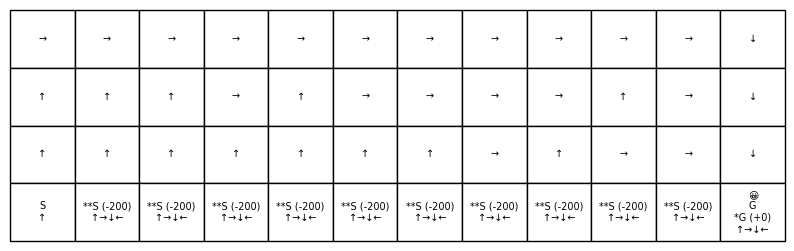

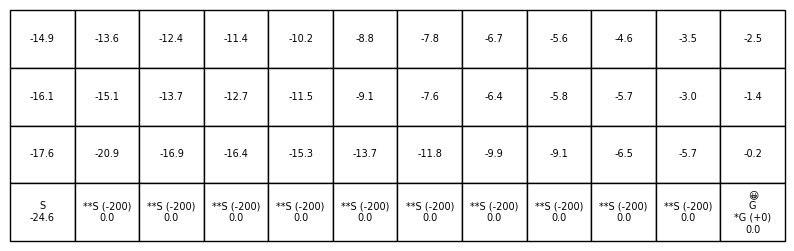

In [55]:
# Plot the optimal policy and state values
policy = dict()
values = dict()

# Compute policy/value for each state
for pos in ALL_STATES:
    qValues = sarsaQValues[pos]
    qMax = max(qValues)
    values[pos] = (1-EPSILON) * qMax + EPSILON * np.mean(qValues) # This is on-policy, assuming epsilon-greedy behavior
    optimalActions = [a for (a, q) in zip(ACTIONS, qValues) if q == qMax]
    policy[pos] = optimalActions

# Plot policy
plt.figure(figsize=(10,3))
gw.drawWorld(drawRewards=False, policy=policy)
plt.show()

# Plot values
plt.figure(figsize=(10,3))
gw.drawWorld(drawRewards=False, values=values)
plt.show()


In [56]:
# A more basic way to plot the policy
labels = ['U', 'R', 'D', 'L']
for i in range(gw.height):
    for j in range(gw.width):
        qValues = sarsaQValues[(i, j)]
        qMax = max(qValues)
        optimalActions = [a for (a, q) in zip(ACTIONS, qValues) if q == qMax]
        if len(optimalActions) > 1:
            print('?', end = ' ')
        else:
            action = optimalActions[0]
            print(labels[action], end = ' ')
    print('')


R R R R R R R R R R R D 
U U U R U R R R R U R D 
U U U U U U U R U R R D 
U ? ? ? ? ? ? ? ? ? ? ? 


In [57]:
# Helper function to play and plot a greedy game (w.r.t. the supplied Q-values)
def illustrateGreedyGame(world: GridWorld, qValues):
    world.reset()
    states = [world.pos]
    action = chooseEpsilonGreedy(qValues, world.pos, 0.0)
    actions = [action]
    rewards = [0]
    while world.pos != GOAL:
        newPos, reward = world.step(action)
        action = chooseEpsilonGreedy(qValues, world.pos, 0.0)
        rewards.append(reward)
        states.append(world.pos)
        actions.append(action)
    plt.figure(figsize=(10,3))
    gw.drawWorld(drawRewards=False, path=states)
    plt.show()
    print('Total reward:', sum(rewards))


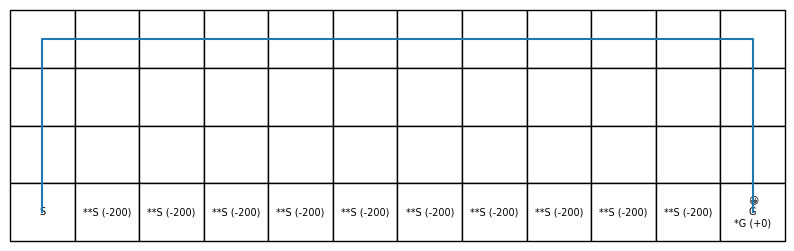

Total reward: -16


In [58]:
illustrateGreedyGame(gw, sarsaQValues)

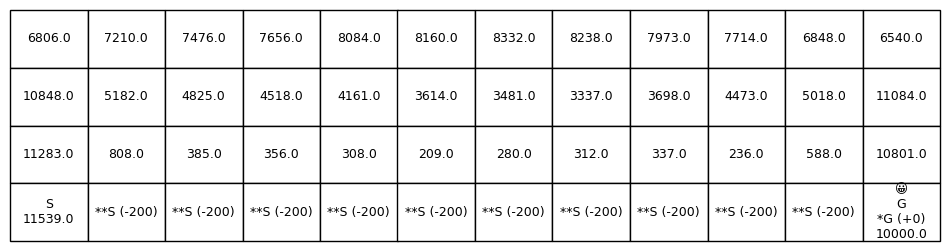

In [59]:
# Count how often each state was visited
sarsaHitCounts = defaultdict(lambda: 0)
for path in sarsaPaths:
    for p in path:
        sarsaHitCounts[p] += 1

# Plot hit counts
plt.figure(figsize=(12, 3))
gw.drawWorld(values=sarsaHitCounts, drawRewards=False)
plt.show()

## Q-Learning

In this section we implement Q-learning to solve the cliff world environment, 
following the pseudocode in *Sutton & Barto*, page 131.

In [60]:
# Initialize Q(s,a) arbitrarily
# Repeat (for each episode):
#     Initialize s
#     Repeat (for each step of episode):
#         Choose a from s using policy derived from Q (e.g., epsilon-greedy)
#         Take action a, observe r, s'
#         Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
#         s <- s';
#     until s is terminal


In [61]:
def qLearningEpisode(world: GridWorld, qValues):
    # Initialize gridworld
    pos = world.reset()

    # Keep some records (not part of Q-learning itself)
    totalRewards = 0.0
    path = [pos]

    # Iterate until we reach a terminal state
    while pos != GOAL:
        # Choose next action from policy
        action = chooseEpsilonGreedy(qValues, pos, EPSILON)

        # Take action, observe reward and new position
        newPos, reward = world.step(action)

        # Update Q-value
        newStateQValues = qValues[newPos]
        target = reward + GAMMA * max(newStateQValues)
        oldQ = qValues[pos][action]
        qValues[pos][action] = oldQ + ALPHA * (target - oldQ)

        # Update state
        pos = newPos

        # Keep some records (not part of Q-Learning itself)
        totalRewards += reward
        path.append(pos)

    return totalRewards, path


In [62]:
# Initialize Q(s,a) arbitrarily
qLearningQValues = defaultdict(lambda: np.zeros(4))

# Keep track of things (not part of Q-Learning itself)
qLearningRewards = []
qLearningPaths = []

# Repeat (for each episode):
for i in range(N_EPISODES):
    [reward, path] = qLearningEpisode(gw, qLearningQValues)
    qLearningRewards.append(reward)
    qLearningPaths.append(path)


We illustrate the results of Q-learning similarly to the results of SARSA.

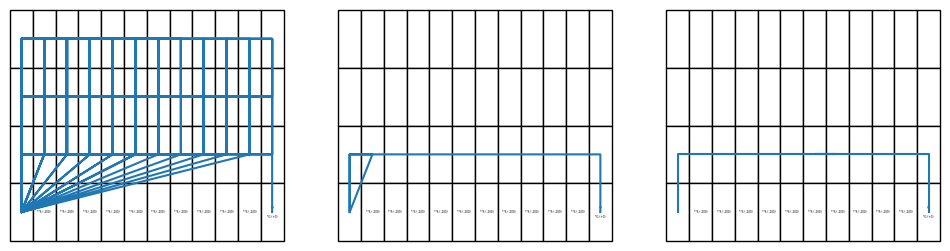

In [63]:
# Plot paths taken at various stages
plt.figure(figsize=(12,3))
ax = plt.subplot(1, 3, 1)
gw.drawWorld(ax, drawRewards=False, path=qLearningPaths[0])
ax = plt.subplot(1, 3, 2)
gw.drawWorld(ax, drawRewards=False, path=qLearningPaths[N_EPISODES // 2])
ax = plt.subplot(1, 3, 3)
gw.drawWorld(ax, drawRewards=False, path=qLearningPaths[-1])
plt.show()

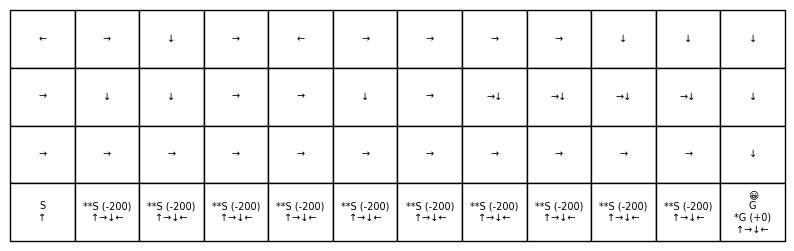

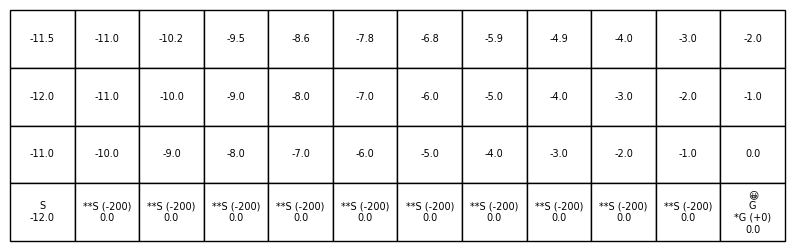

In [64]:
# Plot the optimal policy and state values
policy = dict()
values = dict()

# Plot the optimal policy and state values
for pos in ALL_STATES:
    qValues = qLearningQValues[pos]
    qMax = max(qValues)
    values[pos] = qMax # This is off-policy, so we don't need to consider epsilon
    optimalActions = [a for (a, q) in zip(ACTIONS, qValues) if q == qMax]
    policy[pos] = optimalActions

# Plot policy
plt.figure(figsize=(10,3))
gw.drawWorld(drawRewards=False, policy=policy)
plt.show()

# Plot values
plt.figure(figsize=(10,3))
gw.drawWorld(drawRewards=False, values=values)
plt.show()


In [65]:
labels = ['U', 'R', 'D', 'L']
for i in range(gw.height):
    for j in range(gw.width):
        qValues = qLearningQValues[(i, j)]
        qMax = np.max(qValues)
        optimalLabels = [l for l, q in zip(labels, qValues) if q == qMax]
        if len(optimalLabels) == 1:
            label = optimalLabels[0]
        else:
            label = '?'
        # action = np.argmax(qLearningQValues[(i, j)])
        print(label, end = ' ')
    print('')

L R D R L R R R R D D D 
R D D R R D R ? ? ? ? D 
R R R R R R R R R R R D 
U ? ? ? ? ? ? ? ? ? ? ? 


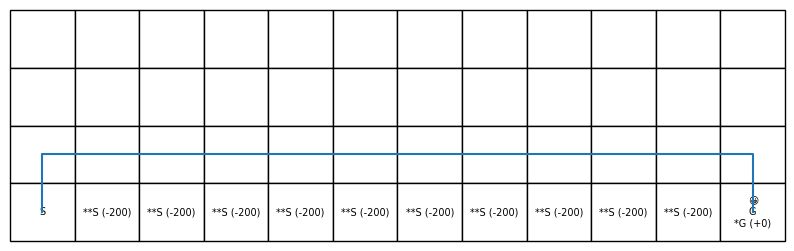

Total reward: -12


In [66]:
illustrateGreedyGame(gw, qLearningQValues)

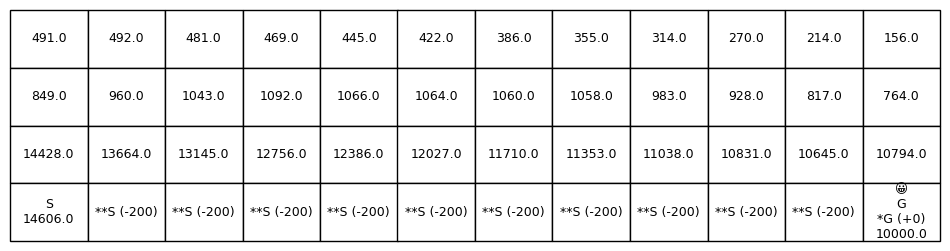

In [67]:
# Count how often each state was visited
qLearningHitCounts = defaultdict(lambda: 0)
for path in qLearningPaths:
    for p in path:
        qLearningHitCounts[p] += 1

# Plot hit counts
plt.figure(figsize=(12, 3))
gw.drawWorld(values=qLearningHitCounts, drawRewards=False)
plt.show()

## Comparison of per-episode rewards

Below we compare the per-episode rewards of SARSA and Q-learning.
Plotting a moving average might be more insightful than raw rewards.

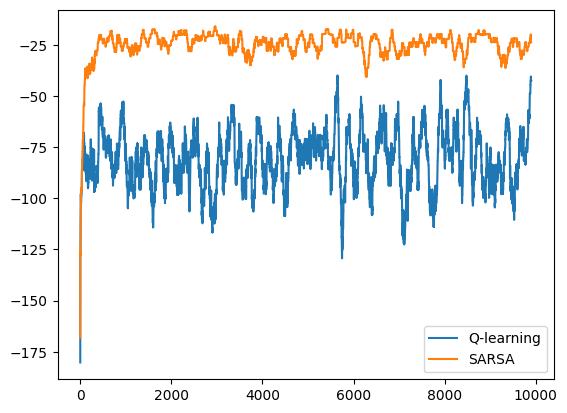

Long-term average rewards
---
Q-learning: -78.8498
SARSA:      -24.5604


In [85]:
# Helper function to compute a moving average
def movingAverage(a, k):
    return np.convolve(a, np.ones(k), 'valid') / k

# Plot (moving average) of per-episode rewards
N_AVERAGE = 100
plt.figure()
plt.plot(movingAverage(qLearningRewards, N_AVERAGE), label='Q-learning')
plt.plot(movingAverage(sarsaRewards, N_AVERAGE), label='SARSA')
plt.legend()
plt.show()

# Compute average over the second half of episodes
print('Long-term average rewards\n---')
print('Q-learning:', np.average(qLearningRewards[N_EPISODES//2:]))
print('SARSA:     ', np.average(sarsaRewards[N_EPISODES//2:]))